## $P(n)$: Multivariate Model Mixing 

### Alexandra Semposki

#### Date: 12 October 2023

We would like to model mix the chiral EFT EOS with the perturbative QCD EOS for Symmetric Nuclear Matter (SNM) using an interpolant between the two regions of model validity. First we set up the two models as `dict`s and then we employ a simple Gaussian Process (GP) to handle the interpolation between the two. Note that both chiral and pQCD EOSs use GPs to quantify their truncation errors, so there are many GPs at work here.

We also load our BMM package, Taweret.

# STOP. 

Have you checked that you're on the correct branch of Taweret?

In [2]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.integrate as sc
import scipy.optimize as opt
import scipy.interpolate as inter
from collections import defaultdict
%matplotlib inline

In [17]:
# import Taweret
import sys
sys.path.append('../../Taweret')
sys.path.append('src/')
sys.path.append('data/')

# import from Taweret all modules
from Taweret.core.base_model import BaseModel
from Taweret.mix.gaussian import Multivariate

In [18]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [9]:
# import the classes for chiral EFT and pQCD
from chiral_model import Chiral_model

from pqcd_reworked import PQCD
from gorda_model import Gorda
from truncation_error import Truncation
from utils import speed_of_sound

In [10]:
# design the GP class we'll need for the interpolant (using GPJaxEmcee results)
class GP_model(BaseModel):
    
    def __init__(self, density, tr_data, std_dev_pqcd, force_equal=False):
        
        # import the data set here
        #gp_test = np.load('gp_map_log_data.npz')
        gp_test = np.load('gp_map_log_data_pqcd_uncorrelated_4pts.npz')
        self.dens_test = gp_test['density']
        self.dens_log = gp_test['dens_log']
        self.mean_test = gp_test['mean']
        self.std_test = gp_test['std']
        self.cov_test = gp_test['cov']
        
        # check density to match
        print(np.allclose(density,self.dens_test))
        
        # first pqcd point in the tr_data
        pqcd_cut = tr_data['density'][2]
        
        # check condition
        if force_equal is True:
            index_cut = np.where(pqcd_cut >= gp_test['density'])[0][-1]
            
            # from here, replace with pqcd real variances
            std_pqcd = std_dev_pqcd[::2]
            for i in range(len(self.dens_test)):
                if i <= 60:
                    self.std_test[i] = gp_test['std'][i]
                elif i > 60:
                    self.std_test[i] = std_pqcd[i]
                
        return None
    
    # mean and std here imported from data set
    def evaluate(self, density):
        
        # return the arrays for mixing
        return self.mean_test, self.std_test
    
    # define prior function
    def set_prior(self):       
        return None 
    
    # define likelihood
    def log_likelihood_elementwise(self):       
        return None

### Training data and model evaluations

Here the models are both evaluated at every training and testing point we'll be using, so that we can save this data and pick the proper training points and testing points for the GP later on.

In [11]:
# define density linspace for training and testing
density = np.linspace(0.05, 16.0, 600)   # pqcd can't really be calculated below 0.4 or so in mu_q

#instantiate pqcd EOS
# pqcdk = PQCD(X=2,Nf=2)

# # take the density and invert to obtain the corresponding mu
# n_q = density*3.0  # n_q [fm^-3]
# # convert to GeV^3 for mu_q
# conversion_fm3 = ((1000.0)**(3.0))/((197.327)**(3.0)) # [fm^-3]  (do the opposite of this)
# n0 = 0.16 
# n_q = n_q/conversion_fm3
# _, mu_n, mu_FG = pqcdk.inversion(n_mu=n_q)

# # evaluate model (N2LO only)
# pqcd = Gorda(mu=mu_n, X=2, Nf=2, mu_FG=mu_FG)
# mean_pqcd, std_dev_pqcd = pqcd.evaluate(N2LO=True, scaled=True)

# # instantiate the chiral EOS
# chiral = Chiral_model(density=density, Lambda=500, high_density=True)

# # evaluate model (N3LO only)
# mean_chiral, std_dev_chiral = chiral.evaluate(N3LO=True, scaled=True, extend=True)

In [12]:
# load training data
#tr_data = np.load('training_data_pqcd_uncorrelated_4pts.npz')
tr_data = np.load('gp_ls4_training_log.npz')
# load the gp data from training
gp_result = np.load('gp_ls4_log.npz')

In [13]:
# instantiate GP model ---> need to fix this part
density_test = density[::2]
#gp_model = GP_model(density_test, tr_data, std_dev_pqcd, force_equal=False)

# test the evaluate function
#mean_gp, std_dev_gp = gp_model.evaluate(density_test) # training and testing the GP model (kernel fixed)

In [14]:
# plot GP by itself first
#plt.ylim(0.0,1.25)
n0 = 0.16 
#plt.xlim(1.0, max(np.log(density/n0)))
#plt.plot(density/n0, mean_chiral, color='red')
#plt.fill_between(density/n0, mean_chiral+std_dev_chiral, mean_chiral-std_dev_chiral, alpha=0.2, color='red')
#plt.plot(density/n0, mean_pqcd, color='blue')
#plt.fill_between(density/n0, mean_pqcd+std_dev_pqcd, mean_pqcd-std_dev_pqcd, alpha=0.2, color='blue')
#plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], color='blue',\
#              fmt='o', markersize=2, capsize=2)
# plt.plot(density_test/n0, mean_gp, color='g')
# plt.xscale('log')
# plt.fill_between(density_test/n0, mean_gp-std_dev_gp, mean_gp+std_dev_gp, alpha=0.2, color='green')
# #plt.xscale('log')

In [15]:
# set up new chiral class for running with pre-selected data
class Chiralmodel(BaseModel):
    
    def __init__(self, density_test, mean_test, std_dev_test):
        
        self.density_test = density_test
        self.mean_test = mean_test
        self.std_dev_test = std_dev_test
        
        return None
    
    def evaluate(self, density):
        
        return self.mean_test, self.std_dev_test
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
class PQCDmodel(BaseModel):
    
    def __init__(self, density_test, mean_test, std_dev_test):
        
        self.density_test = density_test
        self.mean_test = mean_test
        self.std_dev_test = std_dev_test
        
        return None
    
    def evaluate(self, density):
        return self.mean_test, self.std_dev_test
    
    def log_likelihood_elementwise(self):
        return None
    def set_prior(self):
        return None
    
# instantiate both of these models for mixing
# chiral_mixing = Chiralmodel(density_test, mean_chiral[::2], std_dev_chiral[::2])
# pqcd_mixing = PQCDmodel(density_test, mean_pqcd[::2], std_dev_pqcd[::2])

(300,)


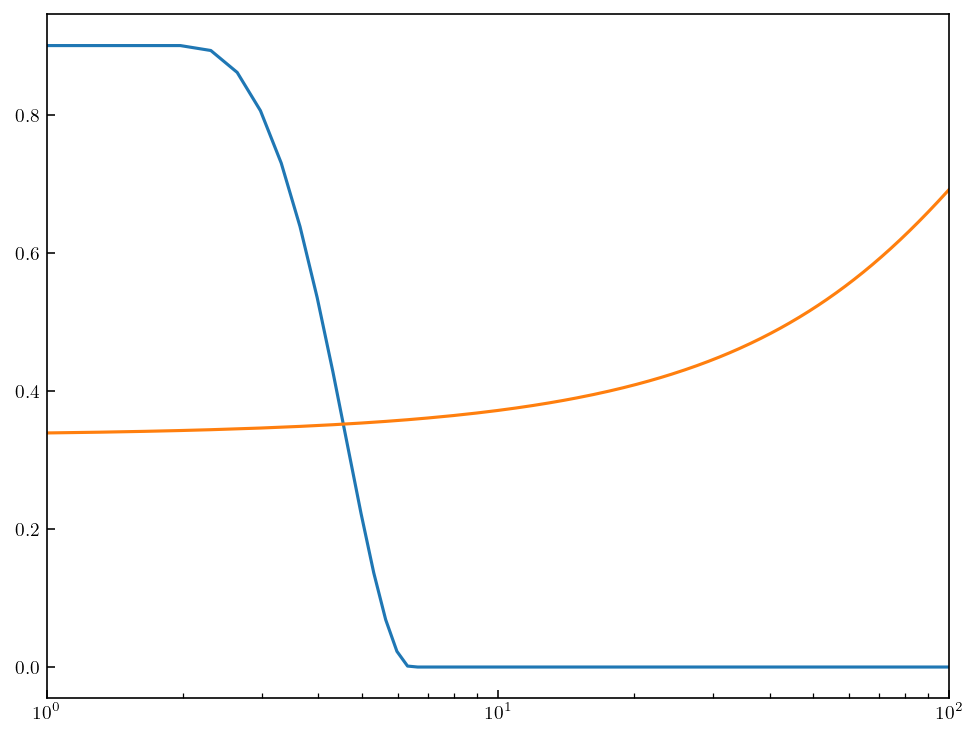

In [16]:
# play with some piecewise cosine parameterisations for the chiral side
def piecewisecos(g, g1, g2, g3):
        
    if g1 > g2 or g2 < g3 or g1 > g3:
        return -np.inf

    if g <= g1:
        return 1.0

    elif g <= g3:
        return (1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

    elif g < g2:
        return 0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0

    else:
        return 0.0
    
# play with some piecewise cosine parameterisations for the pQCD side
def inv_piecewisecos(g, g1, g2, g3):
        
    if g1 > g2 or g2 < g3 or g1 > g3:
        return -np.inf

    if g <= g1:
        return 0.0

    elif g <= g3:
        return 1.0 -(1.0 + np.cos((np.pi/2.0) * ((g - g1)/(g3 - g1))))/2.0

    elif g < g2:
        return 1.0 - (0.5 + np.cos((np.pi/2.0) * (1.0 + ((g - g3)/(g2 - g3))))/2.0)

    else:
        return 1.0
    
# use the chiral EFT lengthscale to determine the width of the crossover region
cosine = np.zeros(len(density_test))
inv_cosine = np.zeros(len(density_test))
for i in range(len(density_test)):
    cosine[i] = piecewisecos(density_test[i], 0.33, 0.33+2*0.348, 0.33+0.348)
    inv_cosine[i] = inv_piecewisecos(density_test[i], 5.0-30.5, 5.0+30.5, 5.0)
plt.plot(density_test/n0, 0.9*cosine)
plt.plot(density_test/n0, 0.9*inv_cosine)
plt.xscale('log')
plt.xlim(1.0, 1e2)
print(cosine.shape)

In [12]:
# mix our models by setting them up and sending to Taweret
# models = {
#     "chiral" : chiral_mixing,
#     "pqcd" : pqcd_mixing,
#     "gp" : gp_model
# }

# # instantiate Multivariate class (using testing density array)
# mixed_model = Multivariate(density_test, models, n_models=len(models))

# # call predict
# # set up the correlation parameter arrays
# R = 0.8*cosine
# S = 0.8*inv_cosine
# _, mixed_mean, mixed_intervals, mixed_std_dev = mixed_model.predict(ci=68, correlated=True, R=R, S=S, T=0)

In [13]:
# check the kernel from pQCD just in case
#print(pqcd.trunc.kernel)

---

In [32]:
# use the conversion from the pQCD code to see if this resolves things
convert_pqcd = np.load('pqcd_fg_data.npz')

# interpolate for a functional form to use 
import scipy.interpolate as interp
convert_interp = interp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

---

NameError: name 'mean_chiral' is not defined

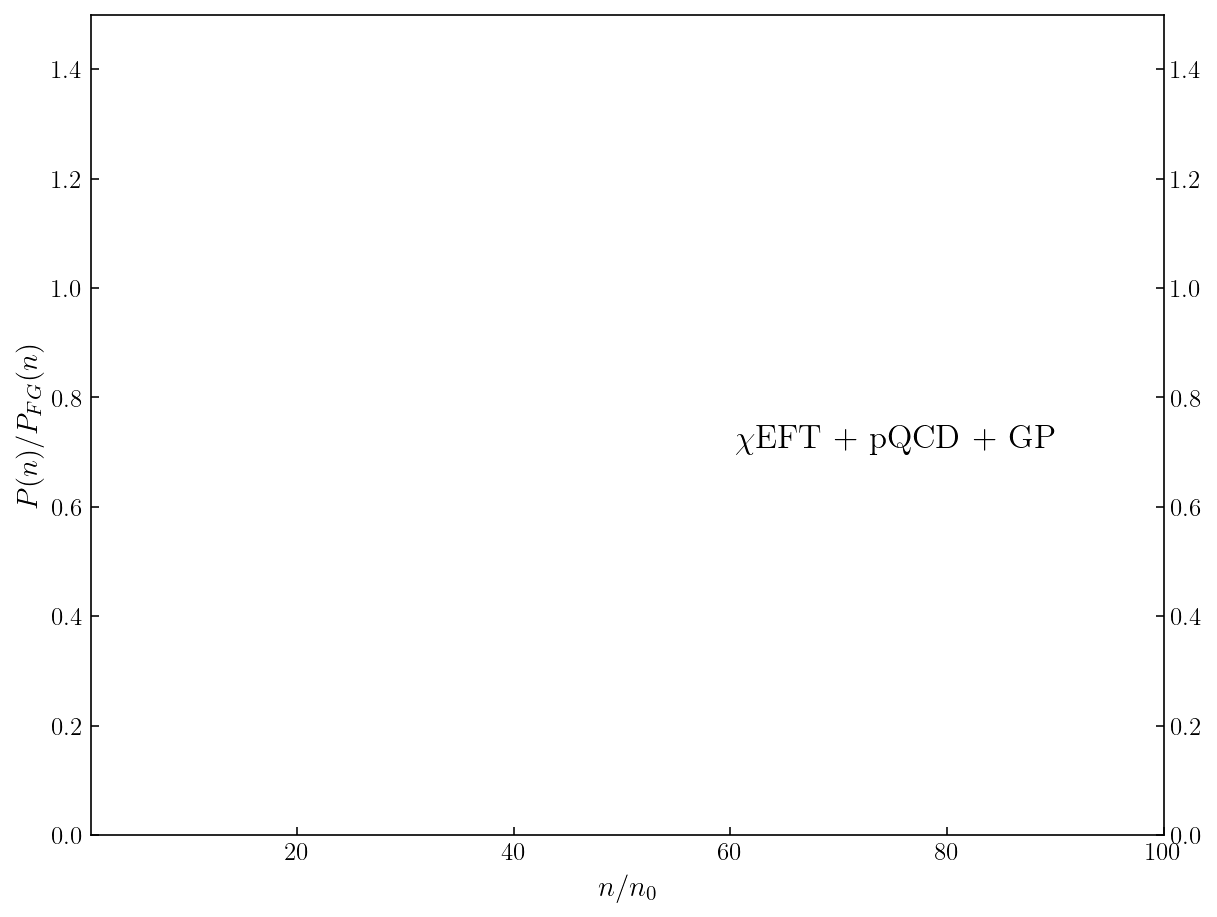

In [19]:
#conversion = (1000)**4.0/(197.33)**3.0

# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# model means
ax.plot(density/n0, mean_chiral, color=colors[0], label=labels[0])
ax.plot(density/n0, mean_pqcd, color=colors[1], label=labels[1])

# PPD mean (testing data array)
ax.plot(density_test/n0, mixed_mean, color='g', label='PPD')

# model uncertainties
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)

# PPD band (testing data array)
ax.fill_between(density_test/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+1.0*mixed_std_dev,
                        zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
import pandas as pd
df = pd.read_csv('contour_scaled.csv')
df_frg = pd.read_csv('frg_data_pressure.csv')
df_hhic = pd.read_csv('hic_data_huth.csv')
df_hfrg = pd.read_csv('frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here 
from nuclear_matter import fermi_momentum, nuclear_density
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)
for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
for i in range(len(density_test)):
    p_fg[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s_fg[i]**4.0))*(hbarc)
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

# plt.plot(density_test/n0, mean_gp, 'g--')
# plt.fill_between(density_test/n0, mean_gp-std_dev_gp, mean_gp+std_dev_gp, color='g', alpha=0.2)

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

# print a slice of 3 variances from the region where they are supposed to be very similar
print('a point in density: ', gp_model.dens_test[100]/n0)
print('std_dev at a training point in density: ', std_dev_chiral[100], std_dev_pqcd[100], gp_model.std_test[100])
print('std_dev for correlated models at the same point: ', mixed_std_dev[100])
print('difference between uncorrelated and correlated result: ', mixed_std_dev[100] - 0.00997347)

In [20]:
# need to check some chemical potentials (because otherwise...)
# get baryon chemical potential
muB = (mu_FG + pqcdk.mu_1(mu_FG) + pqcdk.mu_2(mu_FG))*3*1000 # MeV for baryons # easy to directly do this here
chem_pot_mean, chem_pot_std = chiral.chiral.chemical_potential(method=1, add_rest_mass=True) # in MeV
plt.plot(density/n0, muB, label=r'$\mu$ (pQCD)')
plt.plot(density/n0, chem_pot_mean[:,3], label=r'$\mu$ (Chiral)')
plt.ylim(-0.2,max(chem_pot_mean[:,3]))
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$\mu(n)$ [MeV]')
plt.legend()

NameError: name 'mu_FG' is not defined

## Speed of sound, $c_{s}^{2}(n)$

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn\right] + \varepsilon(min(n)),
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

In [21]:
# point to begin integral
print(density_test[3])

0.20976627712854756


In [22]:
# integration for energy density using Simpson's Rule
import scipy.integrate as scint
import scipy.interpolate as scinterp

# mean
en_0 = 46.52745253488445 # when rest mass is included for ChEFT at 0.05 fm^-3
en_0_lower = 46.525
en_0_upper = 46.530
en_0_half_low = 46.5262
en_0_half_high = 46.5287
p_mean_interp = scinterp.interp1d(density_test[1:], (mixed_mean[1:]*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_lower_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]-mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_upper_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]+mixed_std_dev[1:])*p_fg[1:]), kind='cubic', fill_value='extrapolate')
p_half_low_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]-0.5*mixed_std_dev[1:])*p_fg[1:]), \
                                      kind='cubic', fill_value='extrapolate')
p_half_high_interp = scinterp.interp1d(density_test[1:], ((mixed_mean[1:]+0.5*mixed_std_dev[1:])*p_fg[1:]), \
                                      kind='cubic', fill_value='extrapolate')

def p_mean(n):
    return p_mean_interp(n) / n**2.0
def p_lower(n):
    return p_lower_interp(n) / n**2.0
def p_upper(n):
    return p_upper_interp(n) / n**2.0
def p_half_low(n):
    return p_half_low_interp(n) / n**2.0
def p_half_high(n):
    return p_half_high_interp(n) / n**2.0

en_mean = []
en_lower = []
en_upper = []
en_half_low = []
en_half_high = []

for n in density_test: 
    en_mean.append(n*(en_0/density_test[0] + scint.quad(lambda x : p_mean(x), density_test[0], n)[0]))
    en_lower.append(n*(en_0_lower/density_test[0] + scint.quad(lambda x : p_lower(x), density_test[0], n)[0]))
    en_upper.append(n*(en_0_upper/density_test[0] + scint.quad(lambda x : p_upper(x), density_test[0], n)[0]))
    en_half_low.append(n*(en_0_half_low/density_test[0] + scint.quad(lambda x : p_half_low(x), density_test[0], n)[0]))
    en_half_high.append(n*(en_0_half_high/density_test[0] + scint.quad(lambda x : p_half_high(x), density_test[0], n)[0]))

# dict of energy densities
energy_density = {
    'mean': en_mean,
    'lower': en_lower,
    'upper': en_upper,
    'half_low': en_half_low,
    'half_high': en_half_high
}

NameError: name 'mixed_mean' is not defined

In [23]:
# plot quickly to check validity -> note we need to get out of the scaled system!
plt.plot(density_test/n0, en_mean, label=r'energy density')
plt.plot(density_test/n0, p_mean_interp(density_test), label=r'interpolated pressure')
plt.plot(density_test/n0, mean_pqcd[::2]*p_fg, label=r'pQCD EOS (unmixed)')
plt.plot(density_test/n0, mean_chiral[::2]*p_fg, label=r'ChEFT EOS (unmixed)')
plt.plot(density_test/n0, mixed_mean*p_fg, label=r'mixed pressure')
plt.xlim(1.0, 100.0)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(density_test/n0, p_mean_interp(density_test)/p_fg, label=r'scaled pressure')
plt.xscale('log')
plt.show()

NameError: name 'en_mean' is not defined

In [24]:
# now determine the chemical potential by using the identity
mixed_mean_uns = mixed_mean*p_fg
mixed_std_dev_uns = mixed_std_dev*p_fg
mixed_lower_uns = (mixed_mean-mixed_std_dev)*p_fg
mixed_upper_uns = (mixed_mean+mixed_std_dev)*p_fg
mixed_half_low = (mixed_mean-0.5*mixed_std_dev)*p_fg
mixed_half_high = (mixed_mean+0.5*mixed_std_dev)*p_fg 
chem_mean = (mixed_mean_uns + energy_density['mean'])/density_test
chem_lower = (mixed_lower_uns + energy_density['lower'])/density_test
chem_upper = (mixed_upper_uns + energy_density['upper'])/density_test
chem_half_low = (mixed_half_low + energy_density['half_low'])/density_test
chem_half_high = (mixed_half_high + energy_density['half_high'])/density_test

NameError: name 'mixed_mean' is not defined

In [25]:
# calculate the derivative of the pressure
dpdn_mean = np.gradient(mixed_mean_uns, density_test)
dpdn_lower = np.gradient(mixed_lower_uns, density_test)
dpdn_upper = np.gradient(mixed_upper_uns, density_test)
dpdn_half_low = np.gradient(mixed_half_low, density_test)
dpdn_half_high = np.gradient(mixed_half_high, density_test)

# calculate deriv of energy density
dedn_mean = np.gradient(energy_density['mean'], density_test)
dedn_lower = np.gradient(energy_density['lower'], density_test)
dedn_upper = np.gradient(energy_density['upper'], density_test)

# calculate the speed of sound
cs2_mean = dpdn_mean / chem_mean
cs2_lower = dpdn_lower / chem_upper #chem_lower
cs2_upper = dpdn_upper / chem_lower #chem_upper
cs2_half_low = dpdn_half_low / chem_half_high
cs2_half_high = dpdn_half_high / chem_half_low
cs2_2_mean = dpdn_mean / dedn_mean
cs2_2_lower = dpdn_lower / dedn_lower
cs2_2_upper = dpdn_upper / dedn_upper

# calculating speed of sound without using pressure
dmudn = np.gradient(chem_mean, density_test)
cs2_no_p = (density_test / chem_mean) * dmudn

# calculate sigma of mu
sigma = chem_mean-chem_lower

NameError: name 'mixed_mean_uns' is not defined

NameError: name 'cs2_mean' is not defined

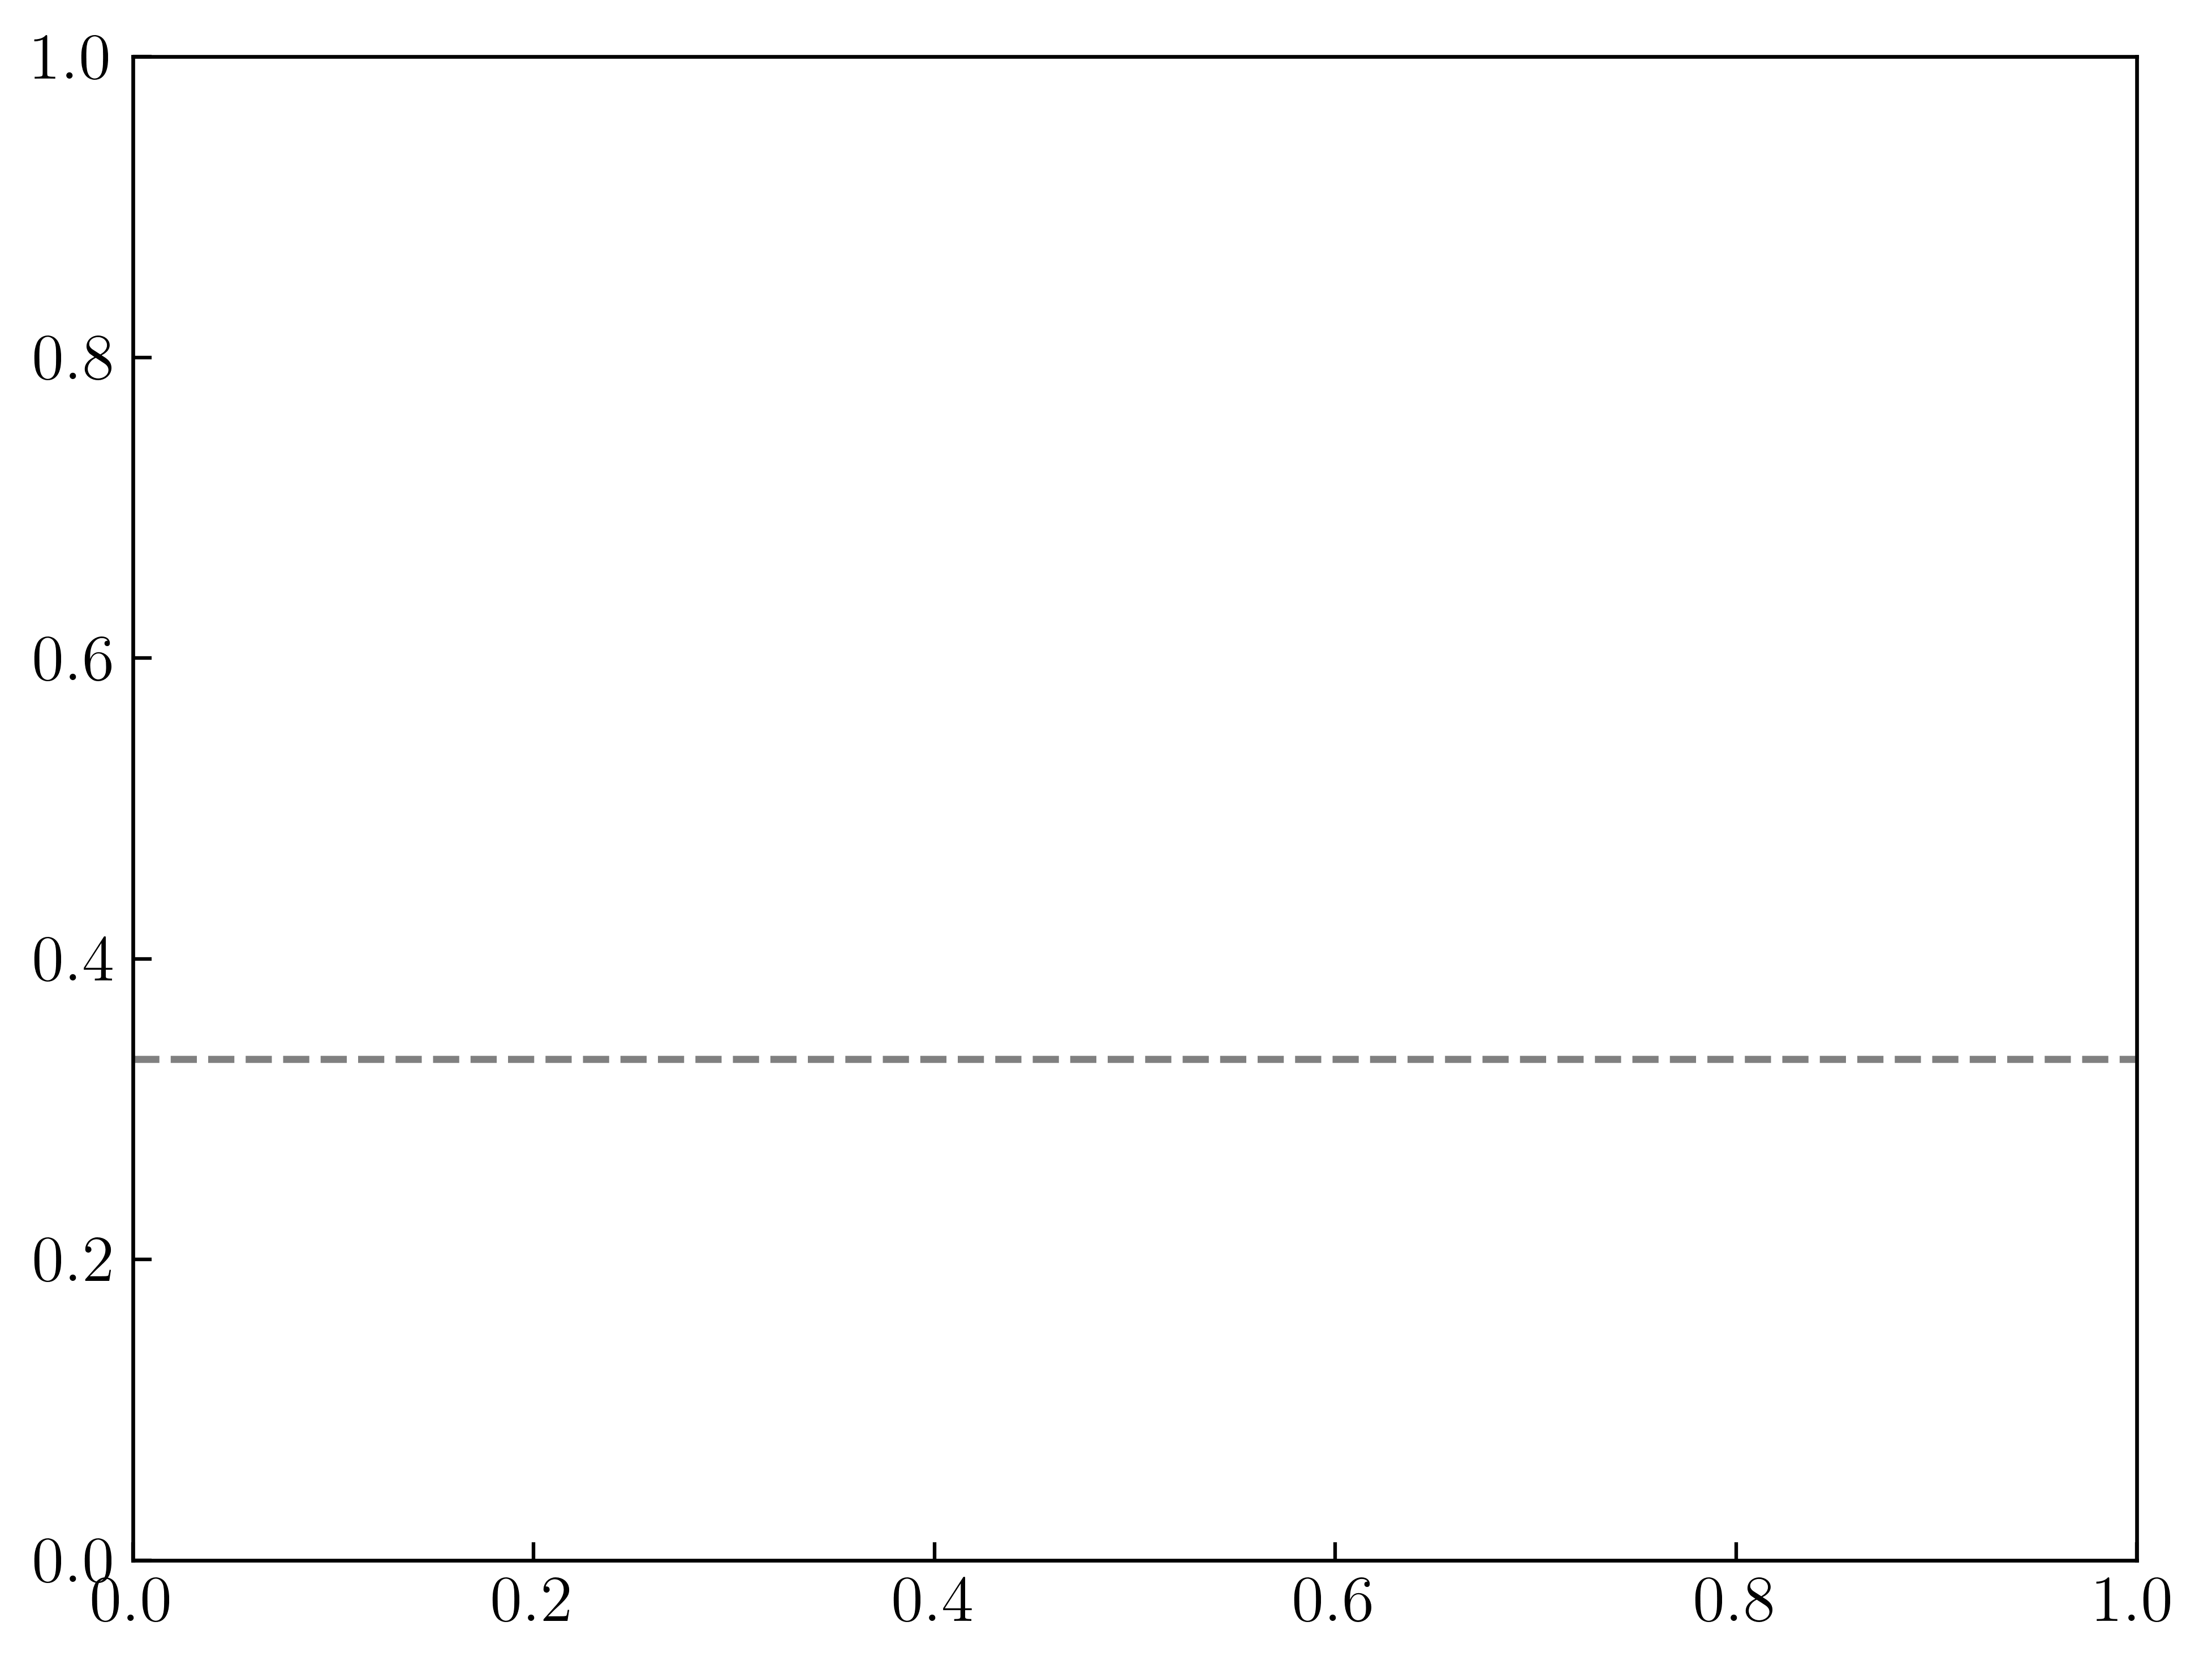

In [26]:
# plot the result quickly (noting the issue with scaling back out of P/P_FG)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

# plt.plot(density_test[:60]/n0, cs2_mean[:60], color='g', linewidth=2, label=r'Mixed Model')
# plt.fill_between(density_test[:60]/n0, cs2_lower[:60], cs2_upper[:60], color='g', alpha=0.2)
plt.plot(density_test/n0, cs2_mean, color='g', linewidth=2, label=r'Mixed model')
plt.fill_between(density_test/n0, cs2_lower, cs2_upper, color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('pqcd_cs2_data.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens[56:]/n0, pqcd_cs2[56:], color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens[56:]/n0, pqcd_lower[56:], pqcd_upper[56:], color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 0.55)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')

# set up the labels
ax.text(0.5,0.5, r'$\chi$EFT', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
plt.show()

print(cs2_mean[-1], pqcd_cs2[-1])
print(pqcd_dens[56]/n0)

## Method 2: GP formalism

### Pressure calculation

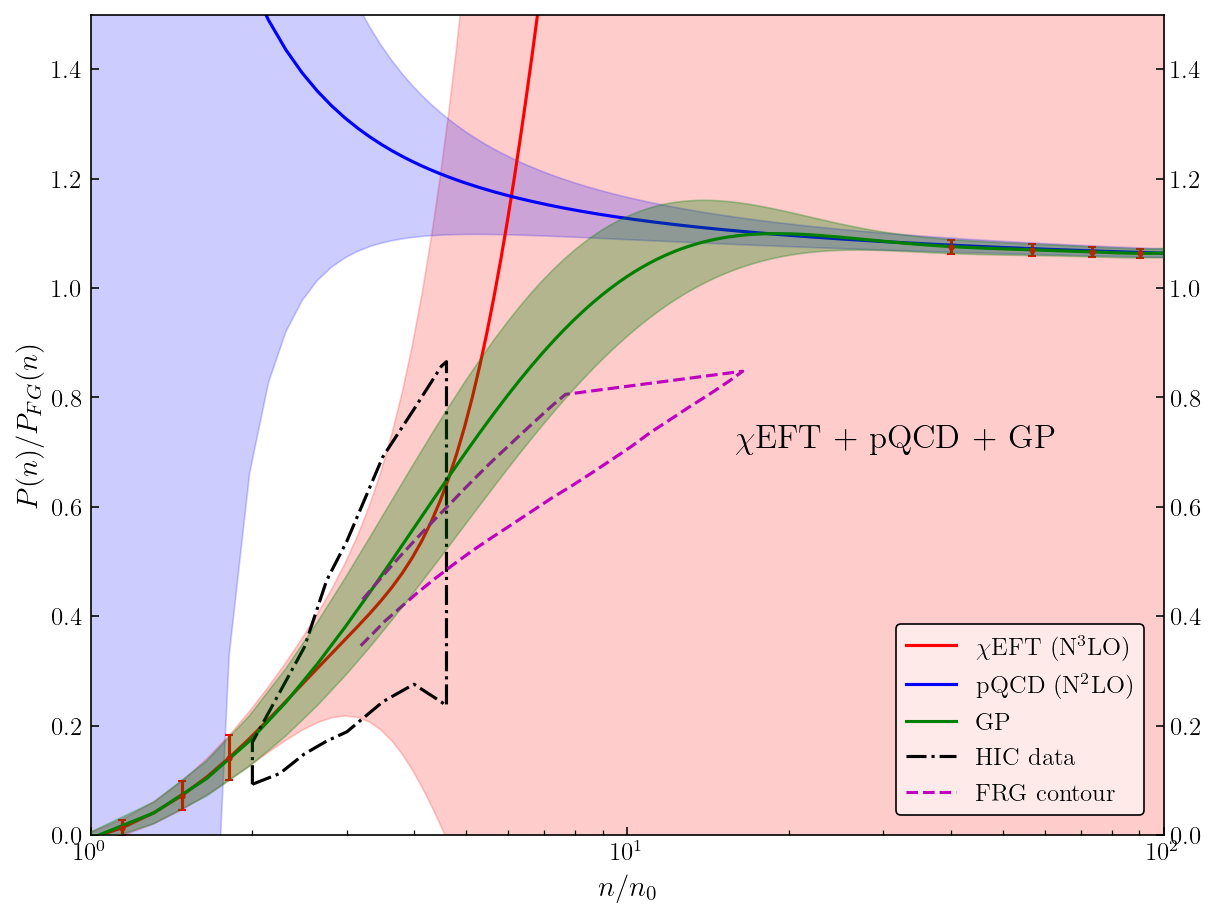

In [33]:
#conversion = (1000)**4.0/(197.33)**3.0 # purely for GeV^4 to MeV/fm^3, not relevant here

# import the data from the ChEFT, pQCD files
chiral_result = np.load('pressure_chiral_data_scaled_cpk.npz')
pqcd_result = np.load('pressure_pqcd_data_scaled_expQ.npz')

# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1., max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# assign means and std devs for easier use
mean_chiral = chiral_result['mean'][:,3]
mean_pqcd = pqcd_result['mean'][:,2]
std_dev_chiral = chiral_result['std_dev'][:,3]
std_dev_pqcd = pqcd_result['std_dev'][:,2]

# model means
ax.plot(density/n0, chiral_result['mean'][:,3], color=colors[0], label=labels[0])
ax.plot(density/n0, pqcd_result['mean'][:,2], color=colors[1], label=labels[1])

# PPD mean (testing data array)
#ax.plot(density_test/n0, mixed_mean, color='g', label='PPD')
ax.plot(gp_result['density']/n0, gp_result['mean'], color='g', label='GP')

# model uncertainties
ax.fill_between(density/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(density/n0, mean_pqcd - 1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                color=colors[1], alpha=0.2)

# PPD band (testing data array)
# ax.fill_between(density_test/n0, mixed_mean-1.0*mixed_std_dev, mixed_mean+1.0*mixed_std_dev,
#                        zorder=5, facecolor='g', edgecolor='g', alpha=0.3)
ax.fill_between(gp_result['density']/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'],
                       zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
import pandas as pd
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
from nuclear_matter import fermi_momentum, nuclear_density
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)
for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
# for i in range(len(density_test)):
#     p_fg[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s_fg[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

# plt.plot(density_test/n0, mean_gp, 'g--')
# plt.fill_between(density_test/n0, mean_gp-std_dev_gp, mean_gp+std_dev_gp, color='g', alpha=0.2)

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

### Speed of sound calculation

In [34]:
# unscale the variables using what we've got for now and store in a dict
pres_dict = {
    'mean': gp_result['mean']*p_fg,
    'std_dev': gp_result['std']*p_fg
}

# 0.05 values for this calculation
en_0 = 46.52745253488445 # when rest mass is included for ChEFT at 0.05 fm^-3
en_0_lower = 46.525
en_0_upper = 46.530

edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function
cs2 = speed_of_sound(density_test, pres_dict, edens_dict)

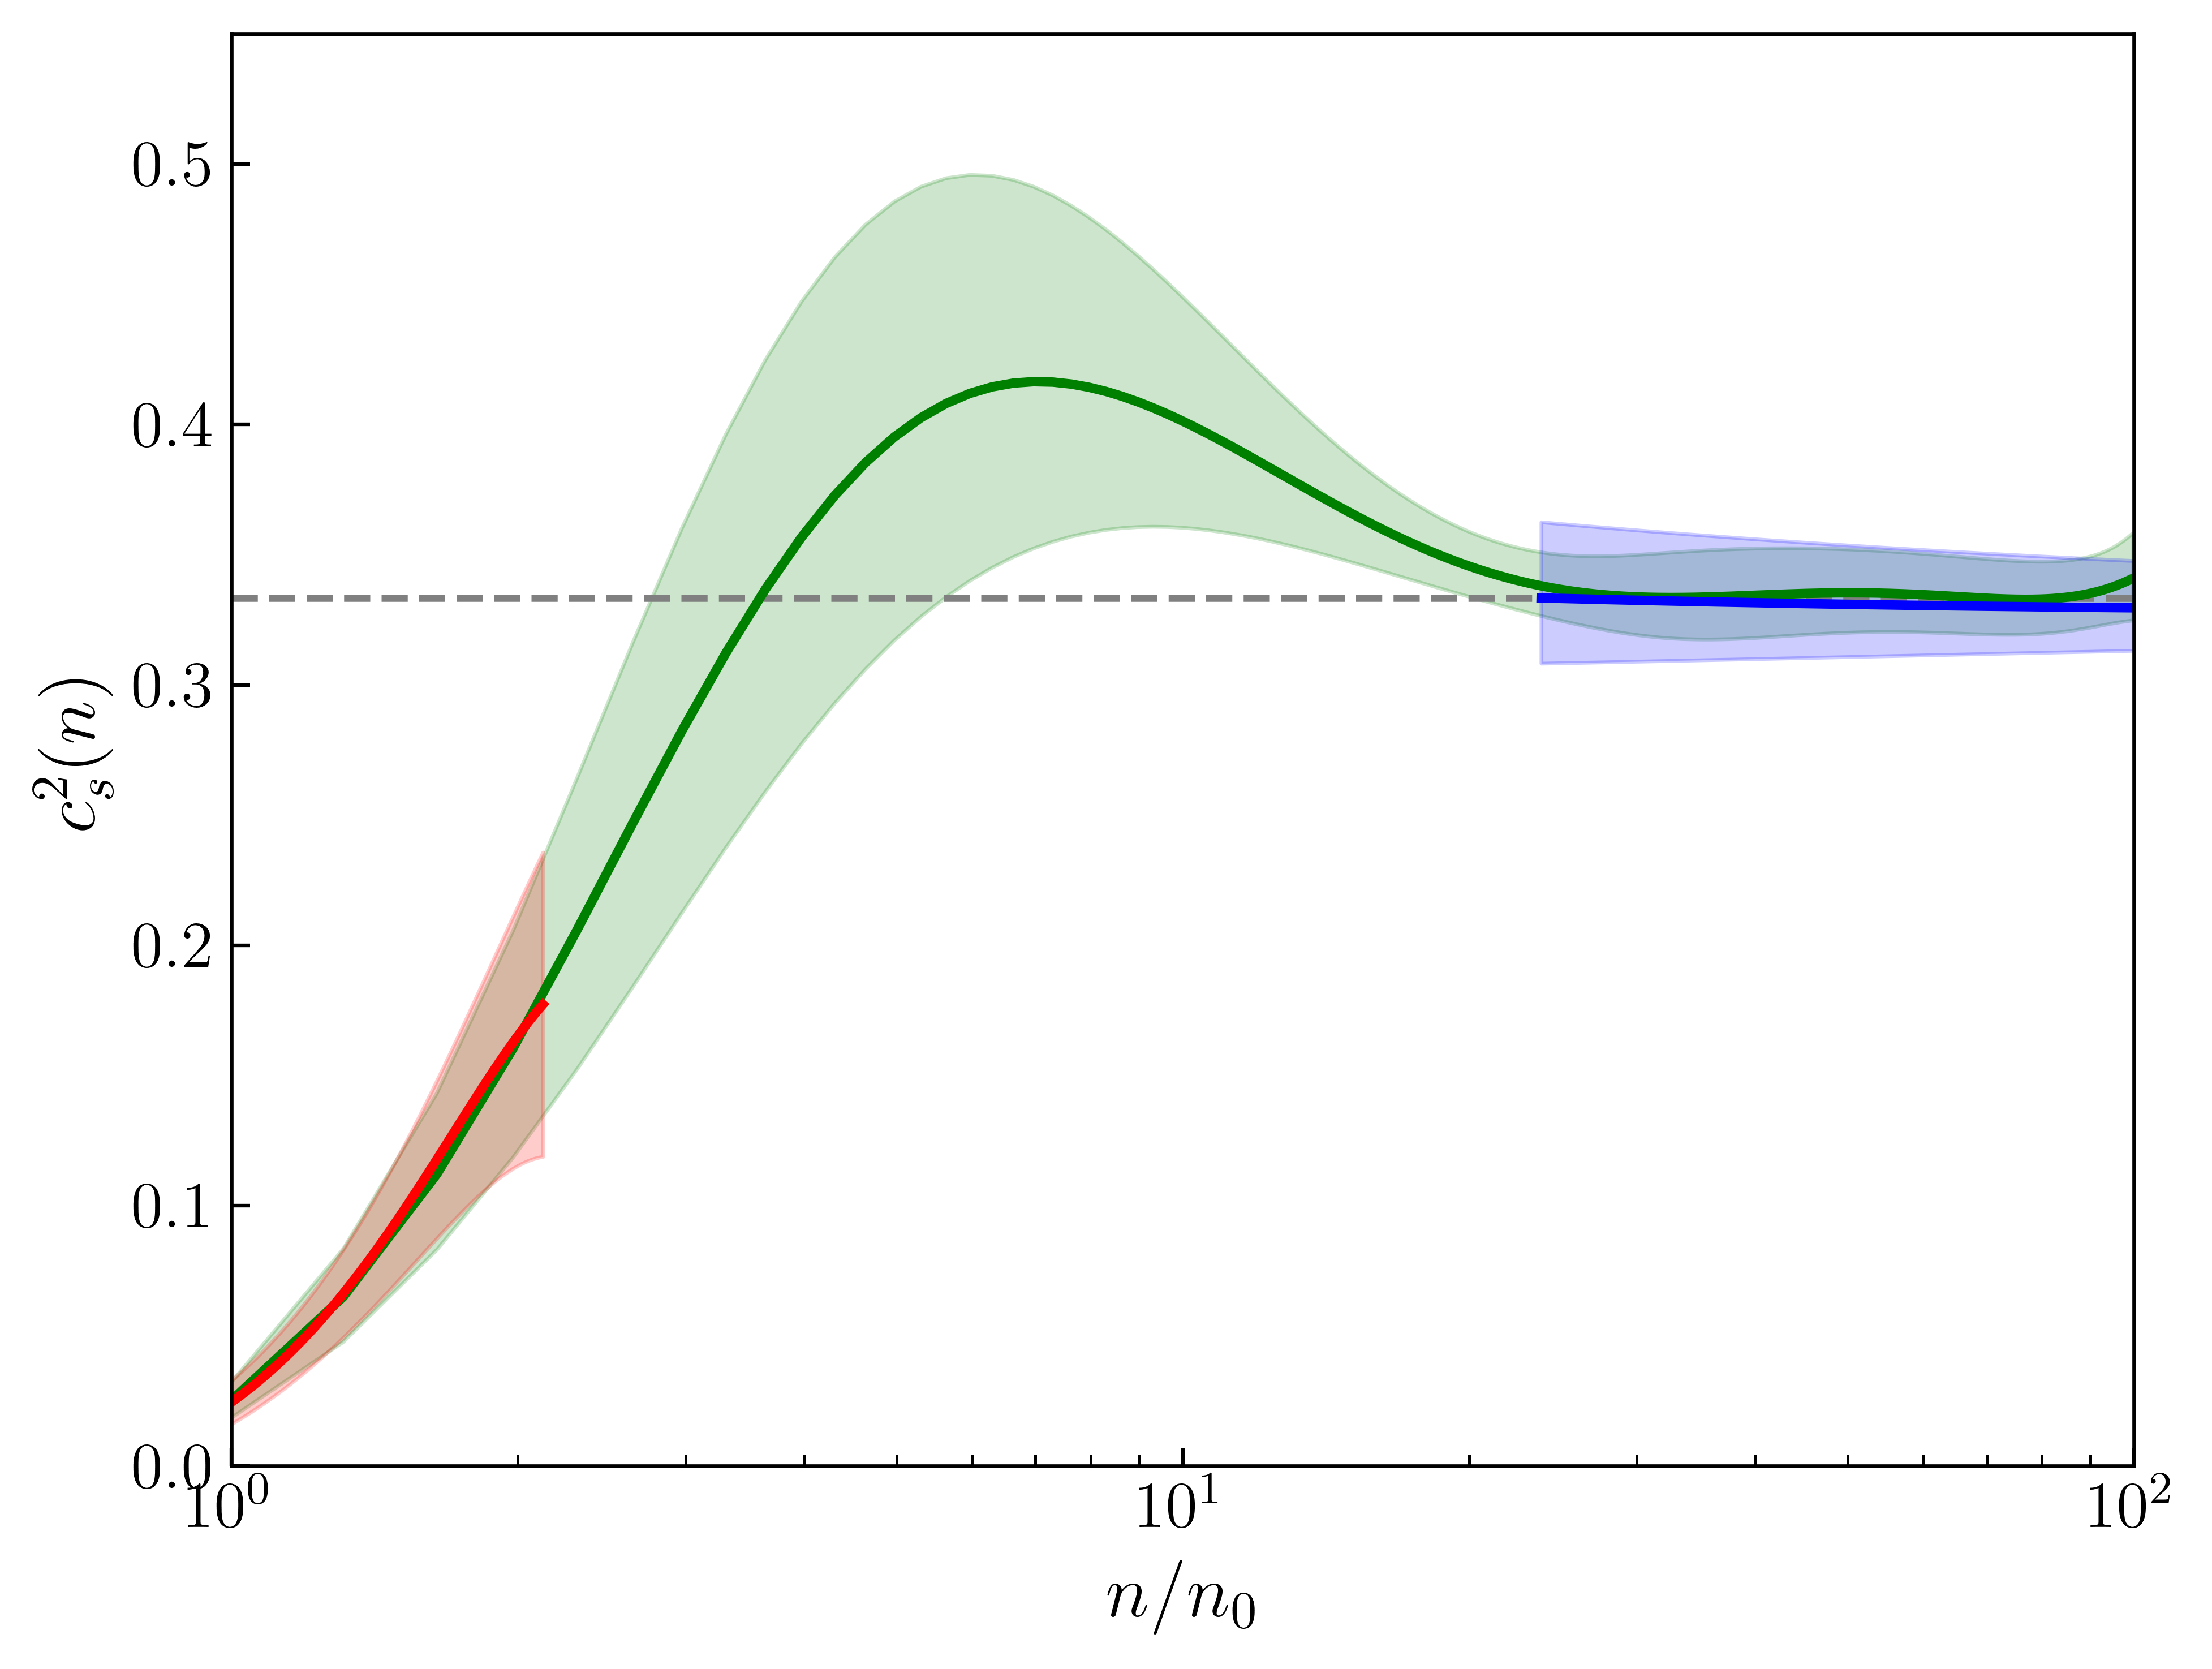

In [35]:
# speed of sound
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 600   # change for paper plots
mpl.rcParams['font.size'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
WIDE_IMG_WIDTH = 800
NARROW_IMG_WIDTH = 400

plt.axhline(y=0.333333, color='grey', linestyle='dashed')

# old constraint :60
plt.plot(density_test/n0, cs2['mean'], color='g', linewidth=2, label=r'Mixed Model')
plt.fill_between(density_test/n0, cs2['lower'], cs2['upper'], color='g', alpha=0.2)

# plot the result from chiral to see differences
npzfile = np.load('speedofsoundchiral.npz')
chiral_mean = npzfile['mean']
chiral_std = npzfile['std']
chiral_dens = npzfile['density']
plt.plot(chiral_dens/n0, chiral_mean[:,3], color='red', linewidth=2, label=r'ChEFT')
plt.fill_between(chiral_dens/n0, chiral_mean[:,3]+chiral_std[:,3], chiral_mean[:,3]-chiral_std[:,3], alpha=0.2, color='red')

# plot the result from pqcd to see differences
npzfile2 = np.load('pqcd_cs2_1.0.npz')
pqcd_cs2 = npzfile2['mean']
pqcd_dens = npzfile2['density']
pqcd_lower = npzfile2['lower']
pqcd_upper = npzfile2['upper']
plt.plot(pqcd_dens[56:]/n0, pqcd_cs2[56:], color='blue', linewidth=2, label=r'pQCD')
plt.fill_between(pqcd_dens[56:]/n0, pqcd_lower[56:], pqcd_upper[56:], color='blue', alpha=0.2)

# plot individual calculation from pQCD as well (using same method, but no energy density integration)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 0.55)
plt.xlabel(r'$n/n_{0}$', fontsize=16)
plt.ylabel(r'$c_{s}^{2}(n)$', fontsize=16)
plt.xscale('log')

# set up the labels
ax.text(0.5,0.5, r'$\chi$EFT', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
plt.show()

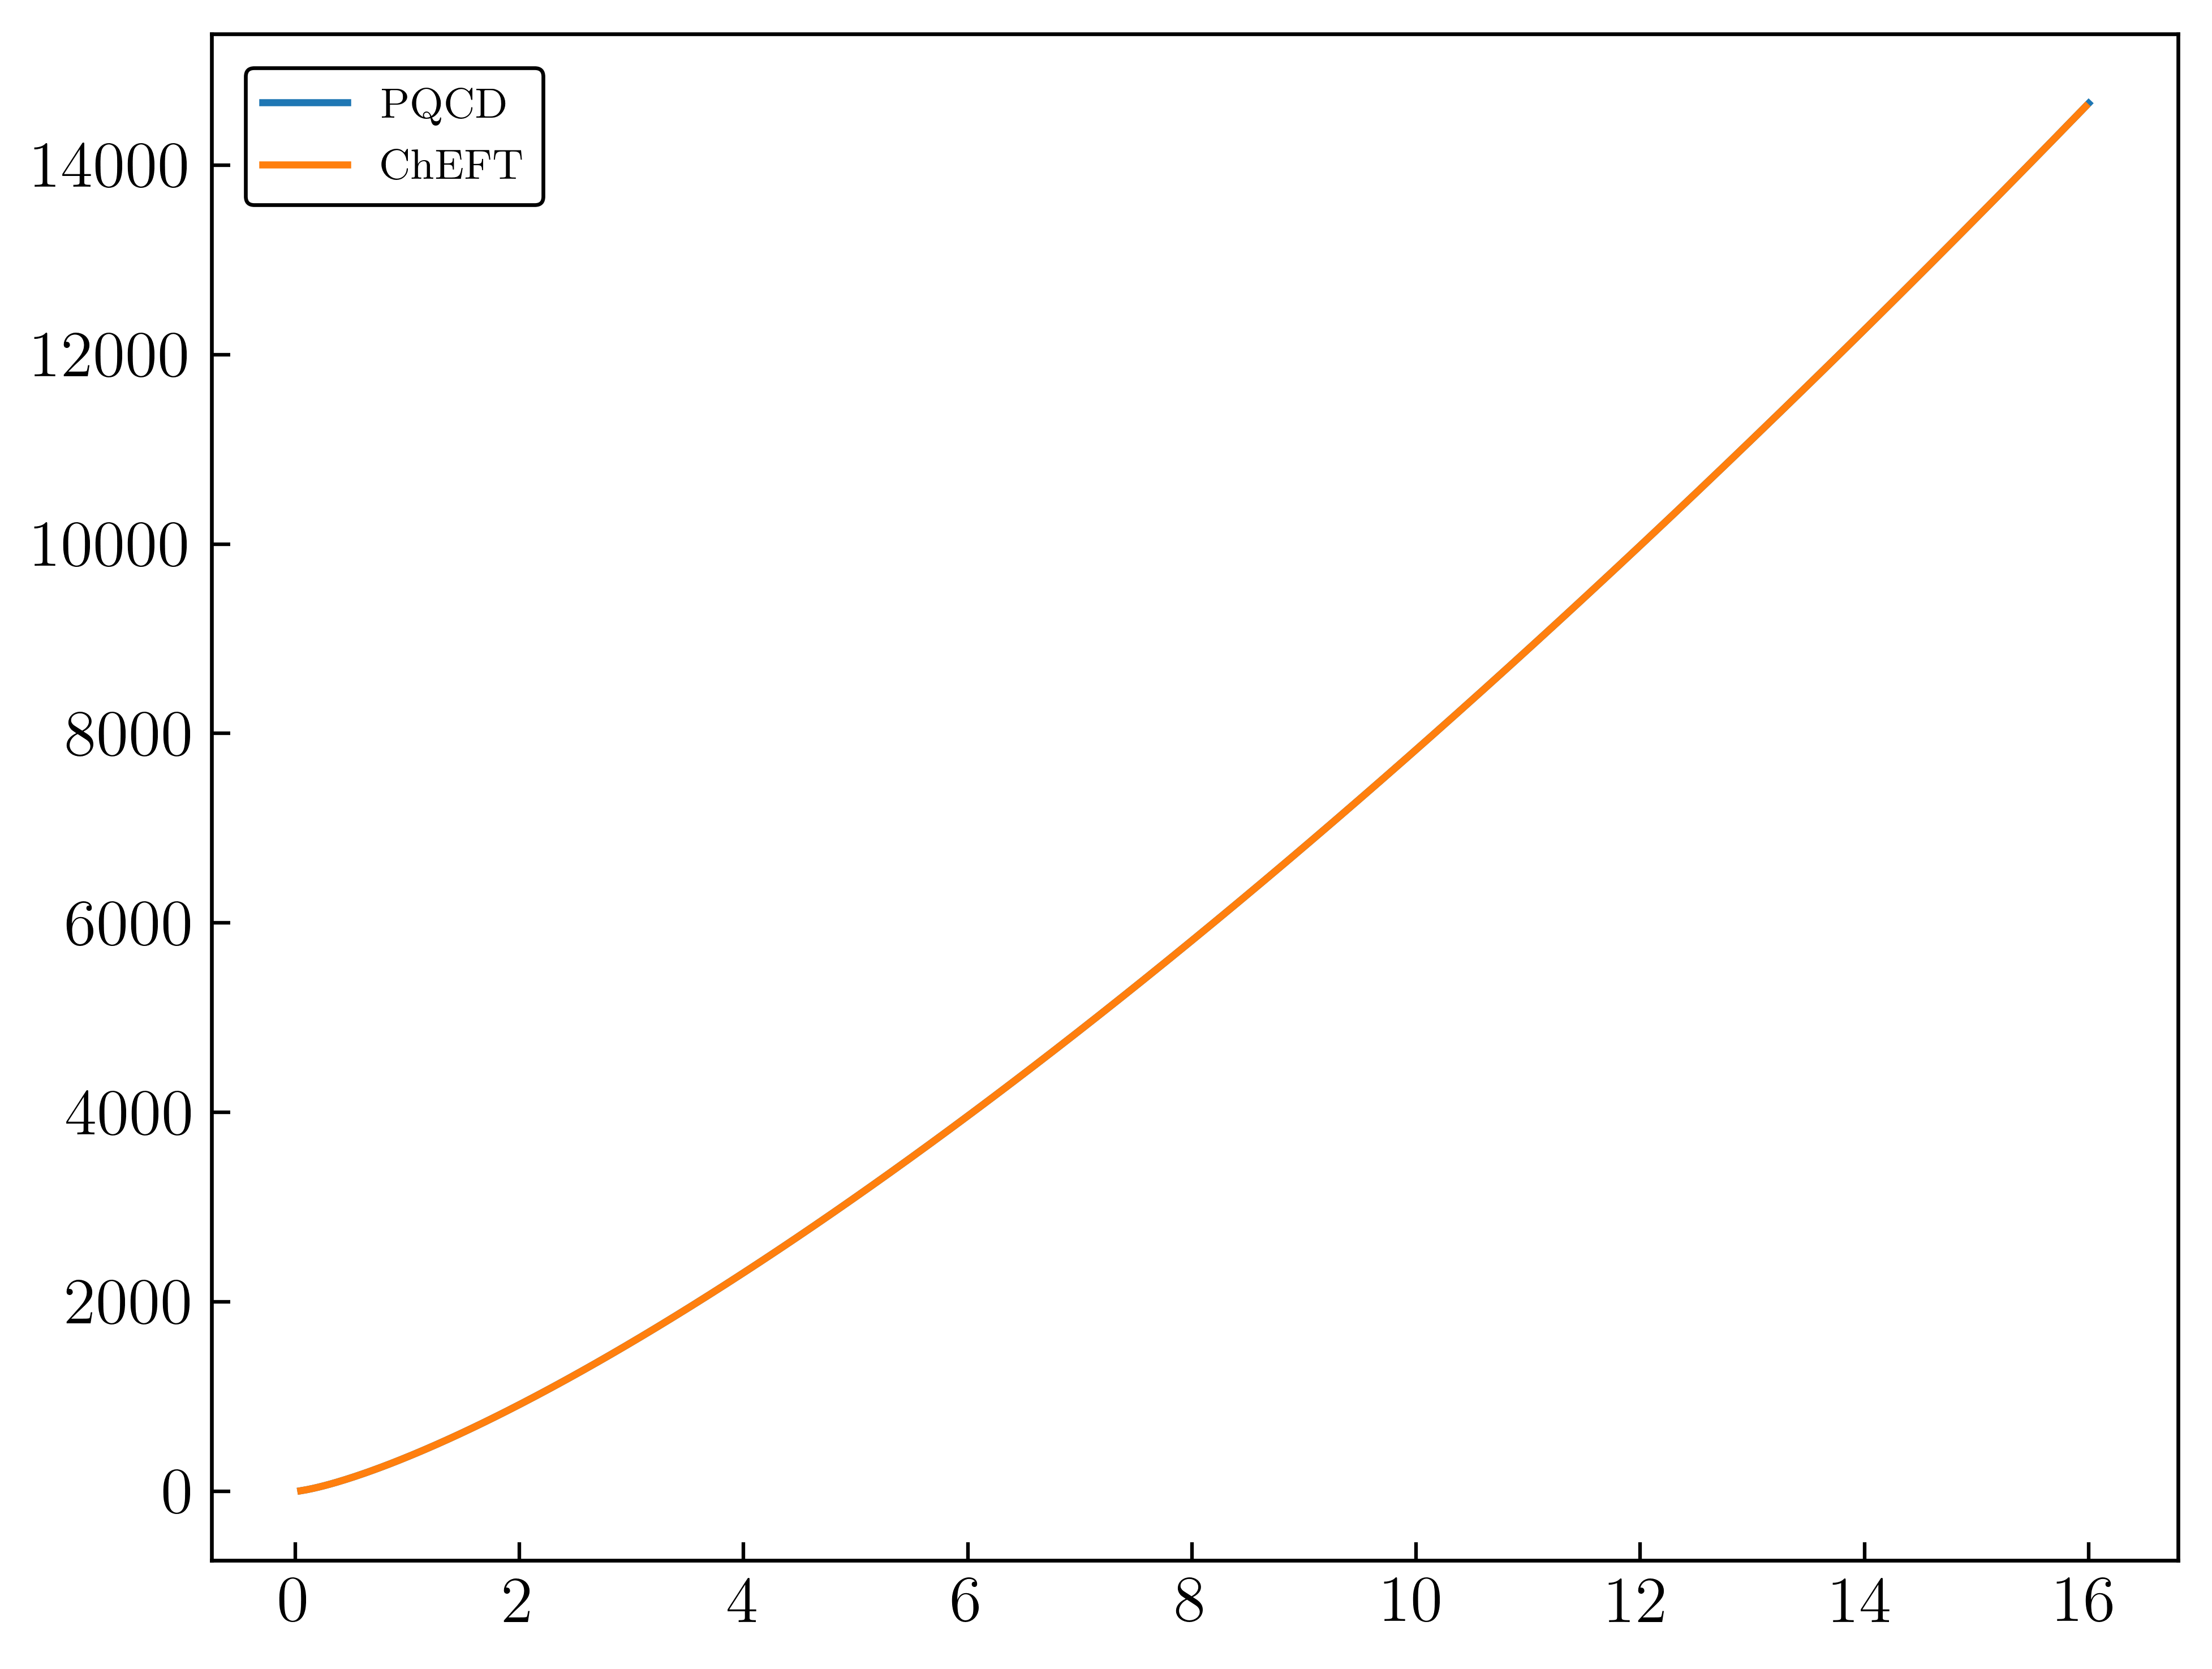

In [39]:
# plot the P_FG values here and those converted from pQCD and see if there are differences
pqcd_fg = np.load('pqcd_fg_data.npz')

plt.plot(pqcd_fg['density'], pqcd_fg['mean'], label=r'PQCD')
plt.plot(density_test, p_fg, label=r'ChEFT')
plt.legend()
plt.show()